Attempt to solve: https://github.com/theislab/scanpy/issues/1366
Probably useful video: https://www.youtube.com/watch?v=h9wxtqoa1jY

In [1]:
import datashader as ds
from datashader import transfer_functions as tf
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from natsort import natsorted

import scanpy as sc
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.neighbors import RadiusNeighborsTransformer

In [2]:
adata = sc.read("/Users/isaac/data/10x_mouse_13MM_processed.h5ad", backed="r")

/Users/isaac/github/anndata/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/isaac/github/anndata/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
louvain_colors_old = dict(
    zip(
        adata.obs["louvain"].cat.categories, 
        adata.uns["louvain_colors"]
    )
)
del adata.uns["louvain_colors"]
louvain_colors_current = sc.pl._tools.scatterplots._get_palette(adata, values_key="louvain")

In [4]:
df = sc.get.obs_df(
    adata,
    ["louvain"],
    obsm_keys=[("X_umap", 0), ("X_umap", 1)]
)

In [5]:
pts = (
    ds.Canvas(500, 500)
    .points(df, "X_umap-0", "X_umap-1", agg=ds.count_cat("louvain"))
)

In [6]:
def pts_to_coords(pts:  xr.DataArray) -> pd.DataFrame:
    """
    Turning pixel data into "long" sparse format.
    
    One entry for each cluster, for each pixel it would occur in.
    """
    coords = pd.DataFrame(np.argwhere(np.asarray(pts)), columns=["x", "y", "cat"])
    coords["cat"] = pd.Categorical.from_codes(coords["cat"], categories=list(pts.coords.values())[2])
    return coords

def color_nodes(graph: dict) -> dict:
    """Graph coloring algorithm
    
    From @atarashansky: https://github.com/theislab/scanpy/issues/1366#issuecomment-763066249
    """
    color_map = {}
    for node in sorted(graph, key=lambda x: len(graph[x]), reverse=True):
        neighbor_colors = set(color_map.get(neigh) for neigh in graph[node])
        color_map[node] = next( 
            color for color in range(len(graph)) if color not in neighbor_colors
        )
    return color_map

def neighboring_clusters(pts: xr.DataArray) -> dict:
    """From array of (pixel, pixel, cluster) find which clusters neighbor eachother.
    """
    graph = {}
    coords = pts_to_coords(pts)
    cat = coords["cat"]

    radius_neighbor = RadiusNeighborsTransformer(metric="euclidean", radius=1)
    radius_neighbor.fit(coords.values[:, :2])
    g = radius_neighbor.radius_neighbors_graph()

    for k, v in coords.groupby("cat").indices.items():
        neighbors = np.unique(g[v].indices)
        graph[k] = natsorted(pd.unique(cat[neighbors]))

    return graph

In [7]:
graph = neighboring_clusters(pts)
palette = {k: sc.pl.palettes.default_28[v] for k, v in color_nodes(graph).items()}

In [8]:
len(set(palette.values()))

25

Current scanpy coloring (38 unique colors out of 100),Graph coloring (25 unique colors),Old scanpy coloring (20 colors w/ repeats)

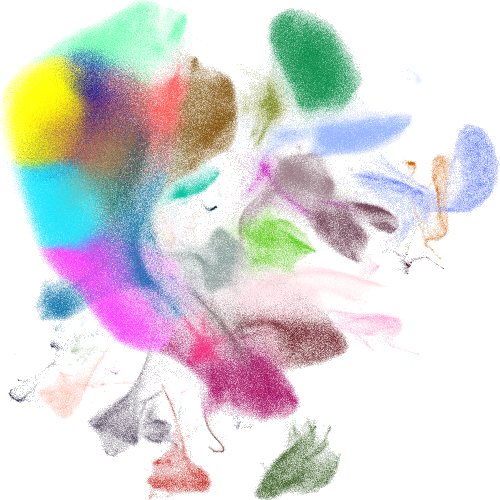
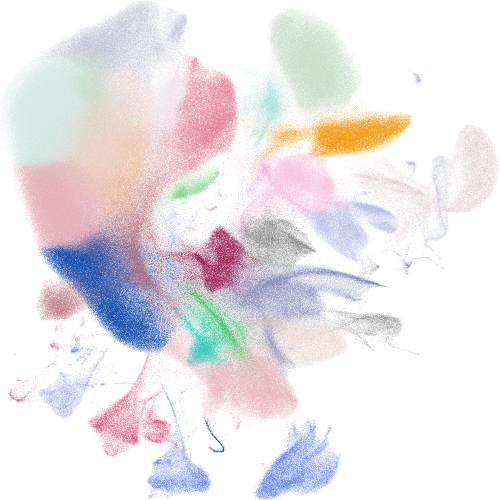
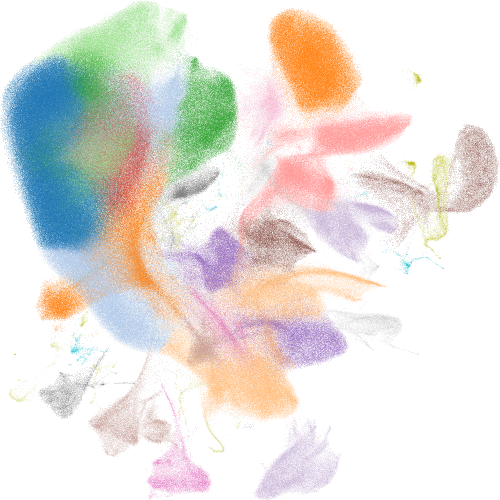

In [9]:
tf.Images(
    tf.shade(pts, color_key=louvain_colors_current, name="Current scanpy coloring (38 unique colors out of 100)"),
    tf.shade(pts, color_key=palette, name="Graph coloring (25 unique colors)"),
    tf.shade(pts, color_key=louvain_colors_old, name="Old scanpy coloring (20 colors w/ repeats)"),
)

# generating distinct colors:

In [10]:
color_map = color_nodes(graph)

In [11]:
# Choosing N distinct colors
# https://github.com/theislab/scanpy/issues/1366#issuecomment-763066249
from typing import Iterable, Tuple
import colorsys
import itertools
from fractions import Fraction

def zenos_dichotomy() -> Iterable[Fraction]:
    """
    http://en.wikipedia.org/wiki/1/2_%2B_1/4_%2B_1/8_%2B_1/16_%2B_%C2%B7_%C2%B7_%C2%B7
    """
    for k in itertools.count():
        yield Fraction(1,2**k)

def fracs() -> Iterable[Fraction]:
    """
    [Fraction(0, 1), Fraction(1, 2), Fraction(1, 4), Fraction(3, 4), Fraction(1, 8), Fraction(3, 8), Fraction(5, 8), Fraction(7, 8), Fraction(1, 16), Fraction(3, 16), ...]
    [0.0, 0.5, 0.25, 0.75, 0.125, 0.375, 0.625, 0.875, 0.0625, 0.1875, ...]
    """
    yield Fraction(0)
    for k in zenos_dichotomy():
        i = k.denominator # [1,2,4,8,16,...]
        for j in range(1,i,2):
            yield Fraction(j,i)

# can be used for the v in hsv to map linear values 0..1 to something that looks equidistant
# bias = lambda x: (math.sqrt(x/3)/Fraction(2,3)+Fraction(1,3))/Fraction(6,5)

HSVTuple = Tuple[Fraction, Fraction, Fraction]
RGBTuple = Tuple[float, float, float]

def hue_to_tones(h: Fraction) -> Iterable[HSVTuple]:
    for s in [Fraction(6,10)]: # optionally use range
        for v in [Fraction(8,10),Fraction(5,10)]: # could use range too
            yield (h, s, v) # use bias for v here if you use range

def hsv_to_rgb(x: HSVTuple) -> RGBTuple:
    return colorsys.hsv_to_rgb(*map(float, x))

flatten = itertools.chain.from_iterable

def hsvs() -> Iterable[HSVTuple]:
    return flatten(map(hue_to_tones, fracs()))

def rgbs() -> Iterable[RGBTuple]:
    return map(hsv_to_rgb, hsvs())

def n_colors(n):
    return list(itertools.islice(rgbs(), n))

In [12]:
colors = n_colors(len(set(color_map.values())))
tarashansky_palette = {k: to_hex(colors[v]) for k, v in color_map.items()}
tarashansky_palette_unique = dict(zip(
    color_map.keys(),
    map(to_hex, n_colors(len(color_map)))
))

non-unique palette,unique palette

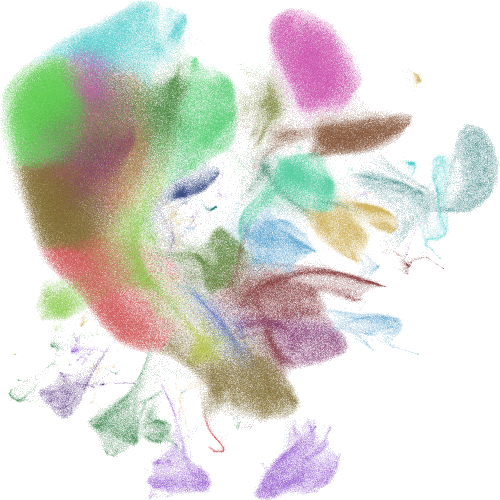
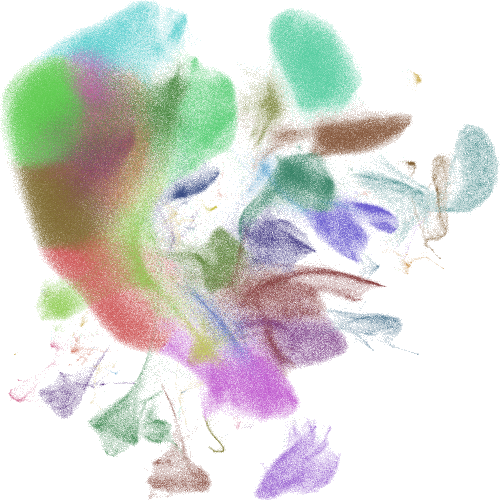

In [13]:
tf.Images(
    tf.shade(pts, color_key=tarashansky_palette, name="non-unique palette"),
    tf.shade(pts, color_key=tarashansky_palette_unique, name="unique palette"),
)